# First basic analysis of input data files
Purpose is:
* do some minimal cleaning (char encoding only) of input data and save result for further usage
* check basic quality of input data 
* Figure train data is similar to challenge data meaning it make sense to train a model

In [1]:
import numpy
import pandas as pandas
import os
import gc
import matplotlib.pyplot as plot
import unicodedata
import seaborn as sns
# This is upposed to enhance default pandas display
pandas.set_option('display.width',120)

Play a little bit with infos from os

*Note*
Only difference between {train/test}_without_quotes_final and {train/test}  is the weird encoding of "" for " inside a field is replaced with a simple '
This allows to easily import data in HANA. Some simple analysis are easy to do with HANA (cf SQL/import_and_sniff{train/test}).

For example, playing with transivity of is_duplicate (A==B) & (B==C) & (A!=C) is easy in SQL

In [2]:
print('Content of input folder: the original data')
file_list = os.listdir('../input')
file_list.sort()
for file in file_list:
        print('%s%.0f\tMB' % (file.ljust(35),os.path.getsize('../input/' + file) / (1024*1024)))

Content of input folder: the original data
test.csv                           299	MB
train.csv                          60	MB


## Time to ingest data

*Note* To avoid further confusion, test dataframe is named challenge_df


In [3]:
# Strong checks are default but I prefer to have it clearly activated
train_dataframe = pandas.read_csv('../input/train.csv',error_bad_lines=True,warn_bad_lines=True)
train_dataframe.metadata = {'title': 'Train'}

challenge_dataframe = pandas.read_csv('../input/test.csv',error_bad_lines=True,warn_bad_lines=True)
challenge_dataframe.metadata = {'title': 'Challenge'}

## Very low level checks:
* How csv has been read (empty value is replaced by a NaN)
* Is there some unicode mess in data

In [4]:
def check_unicode(s):
    if type(s)==str and not unicodedata.is_normalized('NFKD',s):
        return True
    else:
        return False

def check_what_has_been_read(df):
    print('\n%s\n'% df.metadata['title'])
    print('question1 empty and needing to be forced to "": %d' % df['question1'].isnull().sum())
    print('question1 is not a string (a number, a date,...): %d' % df['question1'].apply(lambda s: type(s) !=str).sum())
    print('poorly encoded unicode data in question1: %d' % df['question1'].apply(check_unicode).sum())
    print('question2 and needing to be forced to "": %d' % df['question2'].isnull().sum())
    print('question2 is not a string (a number, a date,...): %d' % df['question2'].apply(lambda s: type(s) !=str).sum())
    print('poorly encoded unicode data in question2: %d' % df['question2'].apply(check_unicode).sum())


check_what_has_been_read(train_dataframe)
check_what_has_been_read(challenge_dataframe)


Train

question1 empty and needing to be forced to "": 1
question1 is not a string (a number, a date,...): 1
poorly encoded unicode data in question1: 1336
question2 and needing to be forced to "": 2
question2 is not a string (a number, a date,...): 2
poorly encoded unicode data in question2: 1247

Challenge

question1 empty and needing to be forced to "": 2
question1 is not a string (a number, a date,...): 2
poorly encoded unicode data in question1: 8229
question2 and needing to be forced to "": 4
question2 is not a string (a number, a date,...): 4
poorly encoded unicode data in question2: 7922


### Some questions are NaN. Some with bad encoding. This will be painfull to manage later. Fix it

In [5]:
def fix_unicode(s):
    if not unicodedata.is_normalized('NFKD',s):
        return unicodedata.normalize('NFKD',s)
    else:
        return s

def fix_what_has_been_read(df):
    print('\nFixing %s\n' % df.metadata['title'])
    print('Fixing Nan')
    df.fillna('',inplace=True)
    print('Fixing unicode')
    a = df['question1'].apply(fix_unicode)
    df['question1'] = a
    a = df['question2'].apply(fix_unicode)
    df['question2'] = a


fix_what_has_been_read(train_dataframe)
fix_what_has_been_read(challenge_dataframe)




Fixing Train

Fixing Nan
Fixing unicode

Fixing Challenge

Fixing Nan
Fixing unicode


Recheck everything

In [6]:
check_what_has_been_read(train_dataframe)
check_what_has_been_read(challenge_dataframe)


Train

question1 empty and needing to be forced to "": 0
question1 is not a string (a number, a date,...): 0
poorly encoded unicode data in question1: 0
question2 and needing to be forced to "": 0
question2 is not a string (a number, a date,...): 0
poorly encoded unicode data in question2: 0

Challenge

question1 empty and needing to be forced to "": 0
question1 is not a string (a number, a date,...): 0
poorly encoded unicode data in question1: 0
question2 and needing to be forced to "": 0
question2 is not a string (a number, a date,...): 0
poorly encoded unicode data in question2: 0


## Do some saves for further usage

In [7]:
def save_dataframe_h5(store,df,name):
    print('Save %s in %s' % (df.metadata['title'],name) )
    if '/'+name in store.keys():
        store.remove(name)
    store[name] = df
    store.get_storer(name).attrs.metadata = df.metadata

def load_dataframe_h5(store,name):
    print ('load %s' % name)
    df= store[name]
    df.metadata = store.get_storer(name).attrs.metadata
    print ('%s has been retrieved in %s ' % (df.metadata['title'], name))
    print('%s contains %d lines' % (df.metadata['title'],len(df)))
    return df


def save_dataframe(df,file_name):
    print('Save %s in %s' % (df.metadata['title'],file_name) )
    df.to_pickle('../PandasStore/'+file_name+'.pkl')
    print('Done')
    

save_dataframe(train_dataframe,'clean_training')
save_dataframe(challenge_dataframe,'clean_challenge')



Save Train in clean_training
Done
Save Challenge in clean_challenge
Done


## Try reloads

In [8]:

def load_dataframe(file_name,title):
    print ('load %s' % file_name)
    df = pandas.read_pickle('../PandasStore/'+file_name+'.pkl')
    print('%s contains %d lines' % (title,len(df)))
    df.metadata={'title':title}
    return df

train_dataframe = load_dataframe('clean_training','Train')
challenge_dataframe = load_dataframe('clean_challenge','Challenge')

load clean_training
Train contains 404290 lines
load clean_challenge
Challenge contains 2345796 lines


# Train

In [9]:
train_dataframe

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0
...,...,...,...,...,...,...
404285,404285,433578,379845,How many keywords are there in the Racket prog...,How many keywords are there in PERL Programmin...,0
404286,404286,18840,155606,Do you believe there is life after death?,Is it true that there is life after death?,1
404287,404287,537928,537929,What is one coin?,What's this coin?,0
404288,404288,537930,537931,What is the approx annual cost of living while...,I am having little hairfall problem but I want...,0


# Challenge

In [10]:
challenge_dataframe

,test_id,question1,question2
0,0,How does the Surface Pro himself 4 compare wit...,Why did Microsoft choose core m3 and not core ...
1,1,Should I have a hair transplant at age 24? How...,How much cost does hair transplant require?
2,2,What but is the best way to send money from Ch...,What you send money to China?
3,3,Which food not emulsifiers?,What foods fibre?
4,4,"How ""aberystwyth"" start reading?",How their can I start reading?
...,...,...,...
2345791,2345791,How do Peaks (TV series): Why did Leland kill ...,What is the most study scene in twin peaks?
2345792,2345792,"What does be ""in transit"" mean on FedEx tracking?",How question FedEx packages delivered?
2345793,2345793,What are some famous Romanian drinks (alcoholi...,Can a non-alcoholic restaurant be a huge success?
2345794,2345794,What were the best and worst things about publ...,What are the best and worst things examination...


# Some basic stats on datasets

Mainly to be sure there is no booby trap in data
* is column 'id' really a key (yes)
* nb pairs, nb duplicates, % duplicates
* is_duplicate is only {0,1]}
* nb pairs obviously equal (same id,same content case sensitive or not)

*Globally no booby trap and no obvious answer*


In [11]:

properties_train={
    'Nb unique id': numpy.sum(train_dataframe['id'].value_counts()==1),
    'Nb pairs': len(train_dataframe),
    'Nb duplicate=1':numpy.sum(train_dataframe['is_duplicate']==1),
    'Nb duplicate': train_dataframe['is_duplicate'].sum(),
    'Unique values in duplicate': train_dataframe['is_duplicate'].unique(),
    'Nb unique values in duplicate': train_dataframe['is_duplicate'].unique().shape[0],
    '% duplicate': round(train_dataframe['is_duplicate'].mean()*100,2),
    'Nb unique qid1': numpy.sum(train_dataframe['qid1'].value_counts()==1),
    'Nb unique qid2': numpy.sum(train_dataframe['qid2'].value_counts()==1),
    'Nb qid1=qid2':numpy.sum(train_dataframe['qid1']==train_dataframe['qid2']),
    'Nb question1=question2': numpy.sum(train_dataframe['question1']==train_dataframe['question2']),
    'Nb lower(question1)=lower(question2)': numpy.sum(train_dataframe['question1'].str.lower()==train_dataframe['question2'].str.lower()),
    'Nb casefold(question1)=casefold(question2)': numpy.sum(train_dataframe['question1'].str.casefold()==train_dataframe['question2'].str.casefold()),
    'mean(len(question1))':round(train_dataframe['question1'].str.len().mean(),2),
    'mean(len(question2))':round(train_dataframe['question2'].str.len().mean(),2)
}


properties_challenge={
    'Nb unique id': numpy.sum(challenge_dataframe['test_id'].value_counts()==1),
    'Nb pairs': len(challenge_dataframe),
    'Nb unique test_id': numpy.sum(challenge_dataframe['test_id'].value_counts()==1),
    'Nb question1=question2': numpy.sum(challenge_dataframe['question1']==challenge_dataframe['question2']),
    'Nb lower(question1)=lower(question2)': numpy.sum(challenge_dataframe['question1'].str.lower()==challenge_dataframe['question2'].str.lower()),
    'lower(question1))=lower(question2)': challenge_dataframe[challenge_dataframe['question1'].str.lower()==challenge_dataframe['question2'].str.lower()][:3],
    'Nb casefold(question1)=casefold(question2)': numpy.sum(challenge_dataframe['question1'].str.casefold()==challenge_dataframe['question2'].str.casefold()),
    'casefold(question1))=casefold(question2)': challenge_dataframe[challenge_dataframe['question1'].str.casefold()==challenge_dataframe['question2'].str.casefold()][:3],
    'mean(len(question1))':round(challenge_dataframe['question1'].str.len().mean(),2),
    'mean(len(question2))':round(challenge_dataframe['question2'].str.len().mean(),2),
}

### Properties of train dataset

In [12]:
properties_train

{'Nb unique id': 404290,
 'Nb pairs': 404290,
 'Nb duplicate=1': 149263,
 'Nb duplicate': 149263,
 'Unique values in duplicate': array([0, 1]),
 'Nb unique values in duplicate': 2,
 '% duplicate': 36.92,
 'Nb unique qid1': 236581,
 'Nb unique qid2': 253733,
 'Nb qid1=qid2': 0,
 'Nb question1=question2': 0,
 'Nb lower(question1)=lower(question2)': 1,
 'Nb casefold(question1)=casefold(question2)': 1,
 'mean(len(question1))': 59.54,
 'mean(len(question2))': 60.11}

### Properties of challenge dataset

In [13]:
properties_challenge

{'Nb unique id': 2345796,
 'Nb pairs': 2345796,
 'Nb unique test_id': 2345796,
 'Nb question1=question2': 60,
 'Nb lower(question1)=lower(question2)': 64,
 'lower(question1))=lower(question2)':        test_id                 question1                 question2
 10620    10620  What is the police code?  What is the police code?
 37823    37823                 How love?                 How love?
 43119    43119                  What is?                  What is?,
 'Nb casefold(question1)=casefold(question2)': 64,
 'casefold(question1))=casefold(question2)':        test_id                 question1                 question2
 10620    10620  What is the police code?  What is the police code?
 37823    37823                 How love?                 How love?
 43119    43119                  What is?                  What is?,
 'mean(len(question1))': 60.12,
 'mean(len(question2))': 60.02}

# Try to graph some basic metrics on datasets

### Comparaison of length of q1 & q2 in train & challenge

Not very useful per se. Just to see if plotting is OK

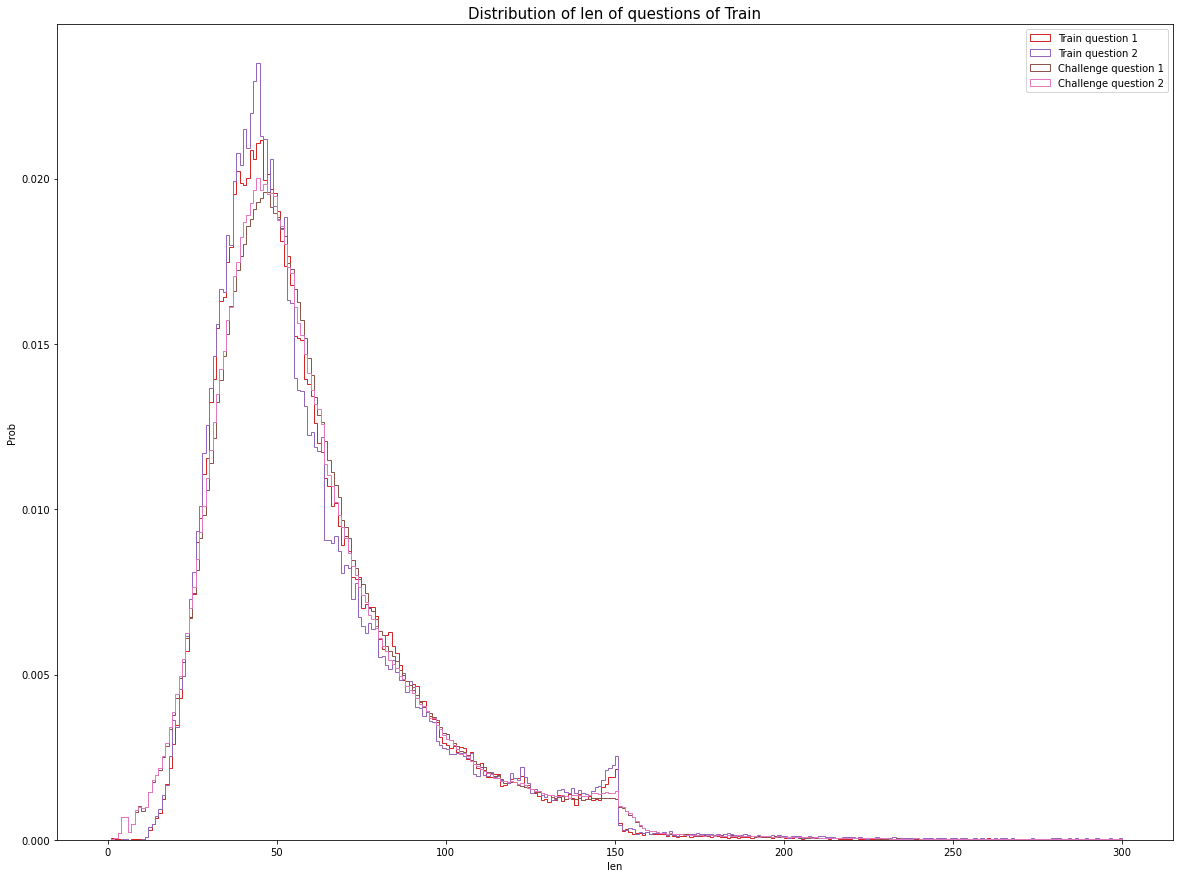

In [14]:
palette = sns.color_palette()
plot.figure(figsize=(20, 15))
plot.hist(train_dataframe['question1'].str.len(),bins=300,range=[0,300],density=True,color=palette[3],label='Train question 1',histtype='step')
plot.hist(train_dataframe['question2'].str.len(),bins=300,range=[0,300],density=True,color=palette[4],label='Train question 2',alpha=1,histtype='step')
plot.hist(challenge_dataframe['question1'].str.len(),bins=300,range=[0,300],density=True,color=palette[5],label='Challenge question 1',histtype='step')
plot.hist(challenge_dataframe['question2'].str.len(),bins=300,range=[0,300],density=True,color=palette[6],label='Challenge question 2',alpha=1,histtype='step')
plot.title('Distribution of len of questions of Train', fontsize=15)
plot.xlabel('len')
plot.ylabel('Prob')
plot.legend()

# Time to challenge a minimal assertion on this challenge: are both datasets really similar ?

Compute more stats and display other graphs so we can be reasonably convinced both datasets are using same 'language'
* Compare distributions of length of questions
* Compare distributions of nb of words
* Compare distribution of length of words

*TO DO* 
* find some indicators with more language semantic
    * nb words in stop words
    * automatic detection of language
    * ...
* Only visual. find some true statistical test to check if 2 distributions are the same

In [17]:
# Merge question1 and question2 for both datasets
all_train_questions = pandas.Series(train_dataframe['question1'].to_list() + train_dataframe['question2'].to_list(),name='question')
all_challenge_questions = pandas.Series(challenge_dataframe['question1'].to_list() + challenge_dataframe['question2'].to_list(),name='question')

# do some counts
# Train
words_of_train_questions = pandas.DataFrame(all_train_questions)
words_of_train_questions['Length'] = all_train_questions.str.len()
words_of_train_questions['NbWords'] = all_train_questions.apply(lambda s: len(s.split(' ')))
words_of_train_questions['MaxLengthWord'] = all_train_questions.apply(lambda s: numpy.max([ len(w) for w in s.split(' ')]))
words_of_train_questions['MeanLengthWord'] = all_train_questions.apply(lambda s: numpy.mean([ len(w) for w in s.split(' ')]))
#Challenge
words_of_challenge_questions = pandas.DataFrame(all_challenge_questions)
words_of_challenge_questions['Length'] = all_challenge_questions.str.len()
words_of_challenge_questions['NbWords'] = all_challenge_questions.apply(lambda s: len(s.split(' ')))
words_of_challenge_questions['MaxLengthWord'] = all_challenge_questions.apply(lambda s: numpy.max([ len(w) for w in s.split(' ')]))
words_of_challenge_questions['MeanLengthWord'] = all_challenge_questions.apply(lambda s: numpy.mean([ len(w) for w in s.split(' ')]))

In [18]:
words_of_train_questions.describe()

,Length,NbWords,MaxLengthWord,MeanLengthWord
count,808580.000000,808580.000000,808580.000000,808580.000000
mean,59.827077,11.064935,9.179605,4.551767
std,31.965704,5.889238,2.552482,0.825441
min,0.000000,1.000000,0.000000,0.000000
25%,39.000000,7.000000,7.000000,4.000000
50%,51.000000,10.000000,9.000000,4.461538
75%,72.000000,13.000000,11.000000,5.000000
max,1169.000000,237.000000,149.000000,36.000000


In [19]:
words_of_challenge_questions.describe()

,Length,NbWords,MaxLengthWord,MeanLengthWord
count,4.691592e+06,4.691592e+06,4.691592e+06,4.691592e+06
mean,6.007475e+01,1.102440e+01,9.211461e+00,4.604982e+00
std,3.162650e+01,5.839969e+00,2.609035e+00,8.617886e-01
min,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
25%,4.000000e+01,7.000000e+00,8.000000e+00,4.000000e+00
50%,5.300000e+01,1.000000e+01,9.000000e+00,4.500000e+00
75%,7.200000e+01,1.300000e+01,1.100000e+01,5.083333e+00
max,1.176000e+03,2.380000e+02,1.390000e+02,5.100000e+01


Use a Kolmogorov-Smirnow to test (H0) if distributions are equivalent

Strange result:
* on the whole dataset, pvalue is either exacty 0, 0.0000...1. so not identical but pvalue looks like a little bit pathologic
* The more I sample the datasets, the more the p value is ... Looks like pvaue is veryr sensitive to size of sample ...

We will stay on simple graphs ...

In [20]:
from scipy.stats import ks_2samp

print('Using a Kolmogorov-Smirnow test')
print('Null hypothesis : the 2 distributions of Length of question are equivalent')
print(ks_2samp(words_of_train_questions['Length'],words_of_challenge_questions['Length']))
print('stat is small but p-value is 0: we reject null hypothesis: distributions are not similar')

Using a Kolmogorov-Smirnow test
Null hypothesis : the 2 distributions of Length of question are equivalent
KstestResult(statistic=0.025501155828280386, pvalue=0.0)
stat is small but p-value is 0: we reject null hypothesis: distributions are not similar


In [21]:
print('Using a Kolmogorov-Smirnow test')
print('Null hypothesis : the 2 distributions of nb words of question are equivalent')
print(ks_2samp(words_of_train_questions['NbWords'],words_of_challenge_questions['NbWords']))
print('stat is small but p-value is 0: we reject null hypothesis: distributions are not similar')

Using a Kolmogorov-Smirnow test
Null hypothesis : the 2 distributions of nb words of question are equivalent
KstestResult(statistic=0.02046498540466546, pvalue=2.342631899880102e-251)
stat is small but p-value is 0: we reject null hypothesis: distributions are not similar


In [22]:
print('Using a Kolmogorov-Smirnow test')
print('Null hypothesis : the 2 distributions of MaxLengthWord of question are equivalent')
print(ks_2samp(words_of_train_questions['MaxLengthWord'],words_of_challenge_questions['MaxLengthWord']))
print('stat is small but p-value is 0: we reject null hypothesis: distributions are not similar')

Using a Kolmogorov-Smirnow test
Null hypothesis : the 2 distributions of MaxLengthWord of question are equivalent
KstestResult(statistic=0.009792888605653444, pvalue=7.00263731846376e-58)
stat is small but p-value is 0: we reject null hypothesis: distributions are not similar


In [23]:
print('Using a Kolmogorov-Smirnow test')
print('Null hypothesis : the 2 distributions of MeanLengthWord of question are equivalent')
print(ks_2samp(words_of_train_questions['MeanLengthWord'].sample(20000,random_state=42),words_of_challenge_questions['MeanLengthWord'].sample(20000,random_state=42)))
print('stat is small but p-value is 0: we reject null hypothesis: distributions are not similar')

Using a Kolmogorov-Smirnow test
Null hypothesis : the 2 distributions of MeanLengthWord of question are equivalent
KstestResult(statistic=0.03490000000000004, pvalue=5.1143563953477895e-11)
stat is small but p-value is 0: we reject null hypothesis: distributions are not similar


## Graph that

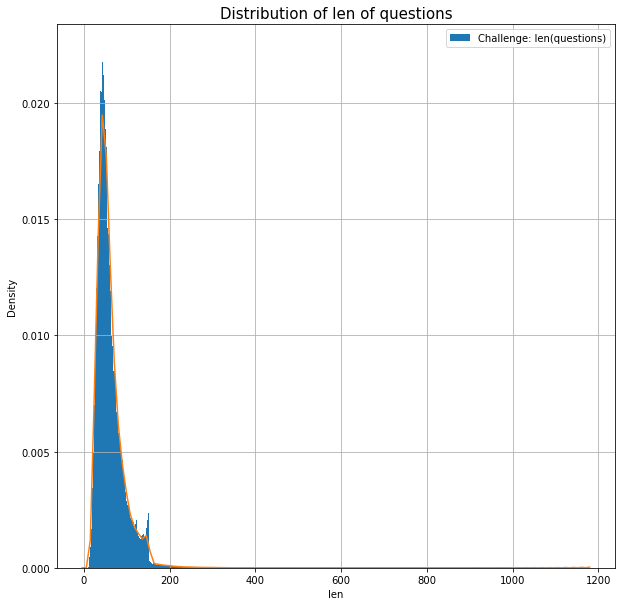

In [24]:
palette = sns.color_palette()
plot.figure(figsize=(10, 10))
plot.hist(all_train_questions.str.len(),bins=300,range=[0,300],density=True,label='Challenge: len(questions)',histtype='bar')
sns.distplot(all_challenge_questions.str.len(),hist=False,kde=True,bins=300)
#sns.distplot(all_challenge_questions.str.len(),hist=False,kde=True,bins=30)
#plot.hist(all_challenge_questions.str.len(),bins=300,range=[0,300],density=True,color=palette[2],label='Challenge questions',alpha=0.5,histtype='step',lw=2,)
plot.title('Distribution of len of questions', fontsize=15)
plot.xlabel('len')
plot.ylabel('Density')
plot.grid(True)
plot.legend()

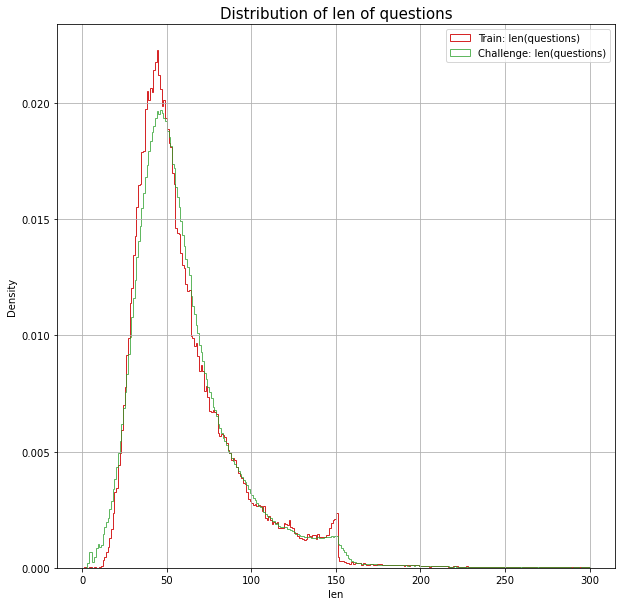

In [25]:
palette = sns.color_palette()
plot.figure(figsize=(10, 10))
plot.hist(all_train_questions.str.len(),bins=300,range=[0,300],density=True,color=palette[3],label='Train: len(questions)',histtype='step')
plot.hist(all_challenge_questions.str.len(),bins=300,range=[0,300],density=True,color=palette[2],label='Challenge: len(questions)',alpha=0.75,histtype='step')
plot.title('Distribution of len of questions', fontsize=15)
plot.xlabel('len')
plot.ylabel('Density')
plot.grid(True)
plot.legend()
plot.savefig('./Distrib_len.png',dpi=300,edgecolor='black',bbox_inches='tight',pad_inches=0.1)

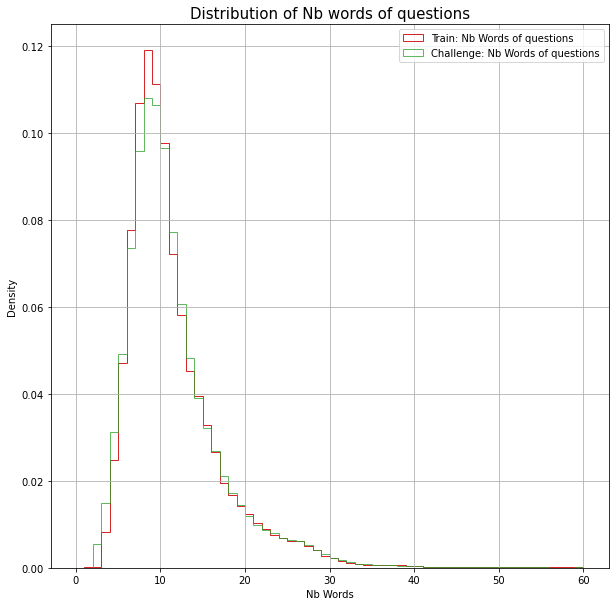

In [99]:
palette = sns.color_palette()
plot.figure(figsize=(10, 10))
plot.hist(words_of_train_questions['NbWords'],bins=60,range=[0,60],density=True,color=palette[3],label="Train: Nb Words of questions",histtype='step')
plot.hist(words_of_challenge_questions['NbWords'],bins=60,range=[0,60],density=True,color=palette[2],label="Challenge: Nb Words of questions",alpha=0.75,histtype='step')
plot.title('Distribution of Nb words of questions', fontsize=15)
plot.xlabel('Nb Words')
plot.ylabel('Density')
plot.grid(True)
plot.legend()
plot.savefig('./Distrib_nb_words.png',dpi=300,edgecolor='black',bbox_inches='tight',pad_inches=0.1)

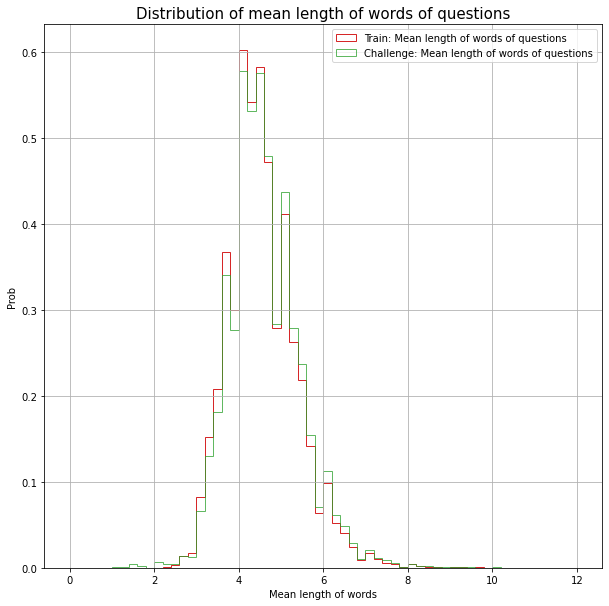

In [26]:
palette = sns.color_palette()
plot.figure(figsize=(10, 10))
plot.hist(words_of_train_questions['MeanLengthWord'],bins=60,range=[0,12],density=True,color=palette[3],label="Train: Mean length of words of questions",histtype='step')
plot.hist(words_of_challenge_questions['MeanLengthWord'],bins=60,range=[0,12],density=True,color=palette[2],label="Challenge: Mean length of words of questions",alpha=0.75,histtype='step')

plot.title('Distribution of mean length of words of questions', fontsize=15)
plot.xlabel('Mean length of words')
plot.ylabel('Prob')
plot.grid(True)
plot.legend()
plot.savefig('./Distrib_mean_words.png',dpi=300,edgecolor='black',bbox_inches='tight',pad_inches=0.1)

## A little bit more stats about questions
* Nb ?
* Nb ' ?'

OK 99% with ? 1% with ' ?' ? is almost always glued to a word. Eliminating stop words won't do anything if we don't fix that.


In [27]:
properties_train['% of questions with ?'] = round(all_train_questions.apply(lambda q: '?' in q).mean()*100,2)
properties_train['% of questions with " ?"'] = round(all_train_questions.apply(lambda q: ' ?' in q).mean()*100,2)
properties_train['% of questions with .'] = round(all_train_questions.apply(lambda q: '.' in q).mean()*100,2)
properties_train

{'Nb unique id': 404290,
 'Nb pairs': 404290,
 'Nb duplicate=1': 149263,
 'Nb duplicate': 149263,
 'Unique values in duplicate': array([0, 1]),
 'Nb unique values in duplicate': 2,
 '% duplicate': 36.92,
 'Nb unique qid1': 236581,
 'Nb unique qid2': 253733,
 'Nb qid1=qid2': 0,
 'Nb question1=question2': 0,
 'Nb lower(question1)=lower(question2)': 1,
 'Nb casefold(question1)=casefold(question2)': 1,
 'mean(len(question1))': 59.54,
 'mean(len(question2))': 60.11,
 '% of questions with ?': 99.88,
 '% of questions with " ?"': 0.41,
 '% of questions with .': 6.35}

In [22]:
properties_challenge['% of questions with ?'] = round(all_challenge_questions.apply(lambda q: '?' in q).mean()*100,2)
properties_challenge['% of questions with " ?"'] = round(all_challenge_questions.apply(lambda q: ' ?' in q).mean()*100,2)
properties_challenge['% of questions with .'] = round(all_challenge_questions.apply(lambda q: '.' in q).mean()*100,2)
properties_challenge

{'Nb unique id': 2345796,
 'Nb pairs': 2345796,
 'Nb unique test_id': 2345796,
 'Nb question1=question2': 60,
 'Nb lower(question1)=lower(question2)': 64,
 'lower(question1))=lower(question2)':        test_id                 question1                 question2
 10620    10620  What is the police code?  What is the police code?
 37823    37823                 How love?                 How love?
 43119    43119                  What is?                  What is?,
 'Nb casefold(question1)=casefold(question2)': 64,
 'casefold(question1))=casefold(question2)':        test_id                 question1                 question2
 10620    10620  What is the police code?  What is the police code?
 37823    37823                 How love?                 How love?
 43119    43119                  What is?                  What is?,
 'mean(len(question1))': 60.12,
 'mean(len(question2))': 60.02,
 '% of questions with ?': 99.39,
 '% of questions with " ?"': 0.41,
 '% of questions with .': 6.94}